## Importing Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Loading Dataset

In [2]:
df = pd.read_csv("../Datasets/New/balanced_priority_task_dataset_missing_values.csv")

In [3]:
df.head(5)

,task_id,task_description,priority,deadline,assigned_to,status,created_at,estimated_hours,actual_hours
0,TASK_89951,Schedule meeting with stakeholders next week.,Medium,2025-08-01,user_37,In Progress,2025-05-26,7.97,6.90
1,TASK_83109,Task needs completion before end of the day.,High,2025-07-11,user_67,To Do,2025-06-13,12.73,14.89
2,TASK_49771,Critical bug in production impacting all users.,Critical,2025-07-01,user_76,Completed,2025-06-08,14.14,12.29
3,TASK_69966,Prepare for upcoming product launch this week.,High,2025-08-07,user_52,To Do,2025-05-24,13.88,17.28
4,TASK_24871,Client report must be submitted by evening.,High,2025-06-29,user_73,To Do,2025-06-05,12.74,14.07


In [4]:
df.shape

(10000, 9)

## check for Missing Values

In [5]:
df.isnull().sum()

task_id               0
task_description    500
priority            500
deadline              0
assigned_to         500
status              500
created_at            0
estimated_hours       0
actual_hours          0
dtype: int64

In [6]:
df.drop_duplicates(inplace=True)
df['task_description'].fillna("No description provided", inplace=True)
df['priority'].fillna(df['priority'].mode()[0], inplace=True)
df['assigned_to'].fillna("unassigned", inplace=True)
df['status'].fillna(df['status'].mode()[0], inplace=True)

df.isnull().sum()

task_id             0
task_description    0
priority            0
deadline            0
assigned_to         0
status              0
created_at          0
estimated_hours     0
actual_hours        0
dtype: int64

## Target Variable : Priority

#### We'll classify tasks based on a target variable. Assuming priority is the target (Low, Medium, High)

In [7]:
label_encoder = LabelEncoder()
df['priority_encoded'] = label_encoder.fit_transform(df['priority'])

In [8]:
df.head()

,task_id,task_description,priority,deadline,assigned_to,status,created_at,estimated_hours,actual_hours,priority_encoded
0,TASK_89951,Schedule meeting with stakeholders next week.,Medium,2025-08-01,user_37,In Progress,2025-05-26,7.97,6.90,3
1,TASK_83109,Task needs completion before end of the day.,High,2025-07-11,user_67,To Do,2025-06-13,12.73,14.89,1
2,TASK_49771,Critical bug in production impacting all users.,Critical,2025-07-01,user_76,Completed,2025-06-08,14.14,12.29,0
3,TASK_69966,Prepare for upcoming product launch this week.,High,2025-08-07,user_52,To Do,2025-05-24,13.88,17.28,1
4,TASK_24871,Client report must be submitted by evening.,High,2025-06-29,user_73,To Do,2025-06-05,12.74,14.07,1


In [9]:
# View encoded classes
print(label_encoder.classes_)

['Critical' 'High' 'Low' 'Medium']


## Feature Extraction using TF-IDF

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert text column to TF-IDF
tfidf = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf.fit_transform(df['task_description'])

# Features (X) and target (y)
X = X_tfidf
y = df['priority_encoded']

In [11]:
X

<10000x112 sparse matrix of type '<class 'numpy.float64'>'
	with 61907 stored elements in Compressed Sparse Row format>

In [12]:
y

0       3
1       1
2       0
3       1
4       1
       ..
9995    3
9996    3
9997    3
9998    0
9999    3
Name: priority_encoded, Length: 10000, dtype: int32

## Train Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
X_train

<8000x112 sparse matrix of type '<class 'numpy.float64'>'
	with 49564 stored elements in Compressed Sparse Row format>

In [15]:
X_test

<2000x112 sparse matrix of type '<class 'numpy.float64'>'
	with 12343 stored elements in Compressed Sparse Row format>

In [16]:
y_train

9254    1
1561    1
1670    3
6087    1
6669    3
       ..
5734    3
5191    3
5390    3
860     2
7270    0
Name: priority_encoded, Length: 8000, dtype: int32

In [17]:
y_test

6252    3
4684    2
1731    1
4742    3
4521    0
       ..
6412    1
8285    2
7853    0
1095    1
6929    1
Name: priority_encoded, Length: 2000, dtype: int32

## Naive Bayes Classification

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict
y_pred_nb = nb_model.predict(X_test)
priority_accuracy = accuracy_score(y_test, y_pred_nb)

# Evaluate
print("Naive Bayes Results:\n")
print(confusion_matrix(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_))
print(f"Accuracy: {priority_accuracy * 100:.2f}%\n")

Naive Bayes Results:

[[478  19  62  14]
 [  0 468  18   0]
 [  0   0 475   0]
 [  0   0  23 443]]
              precision    recall  f1-score   support

    Critical       1.00      0.83      0.91       573
        High       0.96      0.96      0.96       486
         Low       0.82      1.00      0.90       475
      Medium       0.97      0.95      0.96       466

    accuracy                           0.93      2000
   macro avg       0.94      0.94      0.93      2000
weighted avg       0.94      0.93      0.93      2000

Accuracy: 93.20%



## SVM Classification

In [19]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Train model
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# Predict
y_pred_svm = svm_model.predict(X_test)
priority_svm_accuracy = accuracy_score(y_test, y_pred_svm)

# Evaluate
print("SVM Results:\n")
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))
print(f"Accuracy : {priority_svm_accuracy * 100:.2f}%\n")

SVM Results:

[[478  19  62  14]
 [  0 468  18   0]
 [  0   0 475   0]
 [  0   0  23 443]]
              precision    recall  f1-score   support

    Critical       1.00      0.83      0.91       573
        High       0.96      0.96      0.96       486
         Low       0.82      1.00      0.90       475
      Medium       0.97      0.95      0.96       466

    accuracy                           0.93      2000
   macro avg       0.94      0.94      0.93      2000
weighted avg       0.94      0.93      0.93      2000

Accuracy : 93.20%



## Target Variable : Status

#### We'll classify tasks based on a target variable. Assuming status is the target (To Do, In Progress, Done, Blocked)

In [20]:
status_label_encoder = LabelEncoder()
df['status_encoded'] = status_label_encoder.fit_transform(df['status'])

#view encoded class labels
status_label_encoder.classes_

array(['Completed', 'In Progress', 'To Do'], dtype=object)

In [21]:
z = df['status_encoded']

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=42)

In [22]:
z_train

9254    2
1561    0
1670    0
6087    1
6669    1
       ..
5734    2
5191    0
5390    1
860     0
7270    0
Name: status_encoded, Length: 8000, dtype: int32

In [23]:
z_test

6252    2
4684    2
1731    1
4742    2
4521    1
       ..
6412    0
8285    1
7853    2
1095    2
6929    2
Name: status_encoded, Length: 2000, dtype: int32

In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train model
nb_status_model = MultinomialNB()
nb_status_model.fit(X_train, z_train)

# Predict
z_pred_nb = nb_status_model.predict(X_test)
status_accuracy = accuracy_score(z_test, z_pred_nb)

# Evaluate
print("Naive Bayes Results:\n")
print(confusion_matrix(z_test, z_pred_nb))
print(classification_report(z_test, z_pred_nb, target_names=status_label_encoder.classes_))
print(f"Accuracy : {status_accuracy * 100:.2f}%\n")

Naive Bayes Results:

[[ 66 462  98]
 [ 80 546 139]
 [ 58 436 115]]
              precision    recall  f1-score   support

   Completed       0.32      0.11      0.16       626
 In Progress       0.38      0.71      0.49       765
       To Do       0.33      0.19      0.24       609

    accuracy                           0.36      2000
   macro avg       0.34      0.34      0.30      2000
weighted avg       0.35      0.36      0.31      2000

Accuracy : 36.35%



In [25]:
# SVM Classficiation

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Train model
svm_status_model = LinearSVC()
svm_status_model.fit(X_train, z_train)

# Predict
z_pred_svm = svm_status_model.predict(X_test)
status_svm_accuracy = accuracy_score(z_test, z_pred_svm)

# Evaluate
print("SVM Results:\n")
print(confusion_matrix(z_test, z_pred_svm))
print(classification_report(z_test, z_pred_svm, target_names=status_label_encoder.classes_))
print(f"Accuracy : {status_svm_accuracy * 100:.2f}%\n")

SVM Results:

[[ 35 545  46]
 [ 36 665  64]
 [ 27 531  51]]
              precision    recall  f1-score   support

   Completed       0.36      0.06      0.10       626
 In Progress       0.38      0.87      0.53       765
       To Do       0.32      0.08      0.13       609

    accuracy                           0.38      2000
   macro avg       0.35      0.34      0.25      2000
weighted avg       0.35      0.38      0.27      2000

Accuracy : 37.55%



## Overall Results till now

| Metrics  | Naive Bayes | SVM    | Target Variable |
| -------- | ----------- | ------ | --------------- |
| Accuracy | 93.20%      | 93.20% | Priority        |
| Accuracy | 36.35%      | 37.55% | Status          |

## Visualizations

## 1. Confusion Matrix

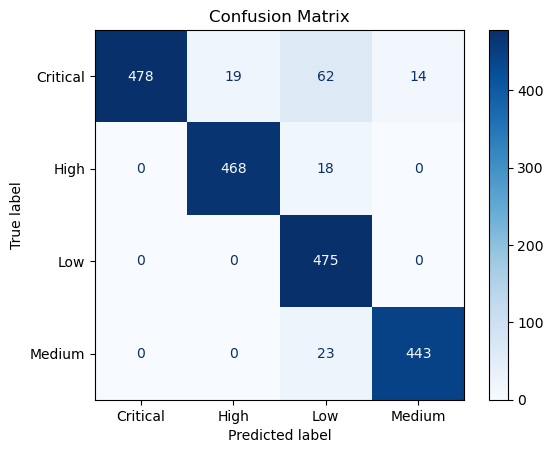

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

## 2. Classification Report Heatmap

#### Visualize precision, recall, and f1-score for each class.

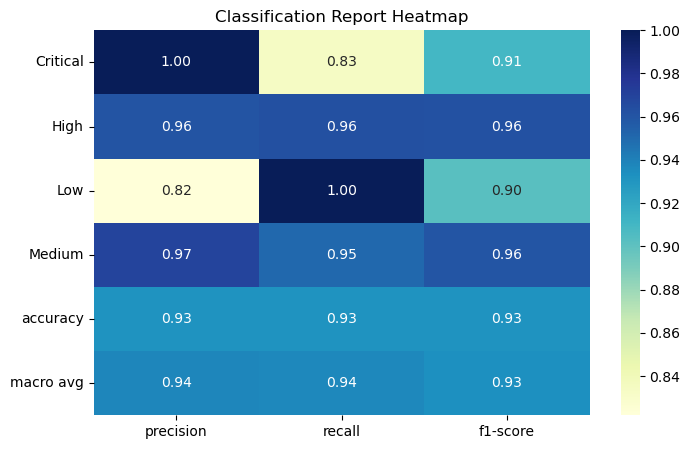

In [27]:
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

report = classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 5))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report Heatmap")
plt.show()

## 3. WordCloud of Task Descriptions (Per Class)

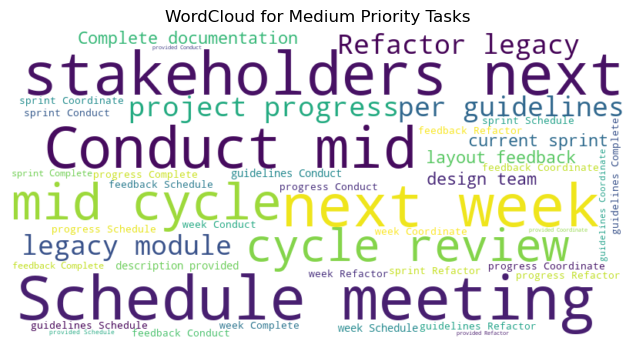

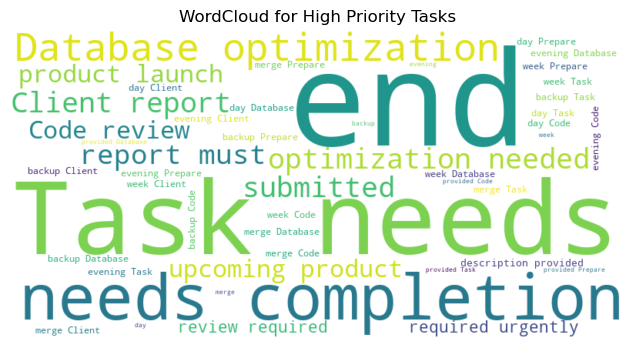

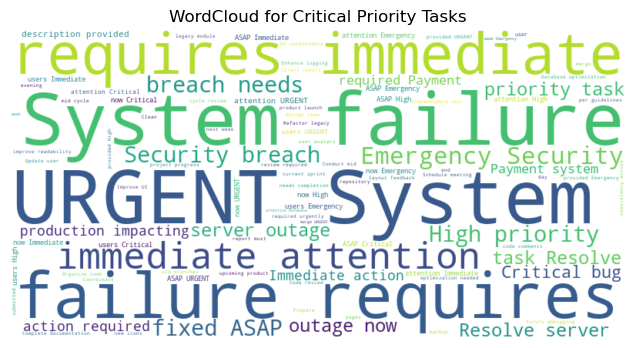

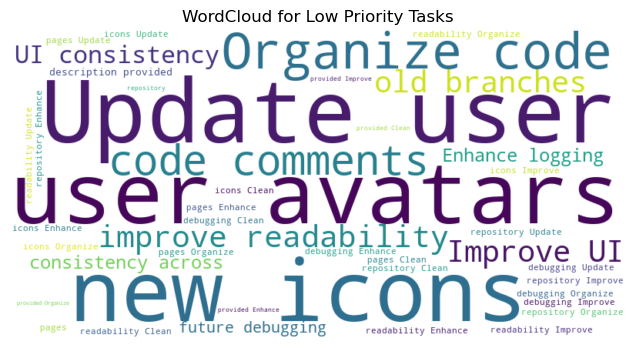

In [28]:
from wordcloud import WordCloud

for label in df['priority'].unique():
    text = " ".join(df[df['priority'] == label]['task_description'].dropna())
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for {label} Priority Tasks")
    plt.show()

## Most used Top Words

In [29]:
import numpy as np

def show_top_words(classifier, vectorizer, class_labels, n=10):
    feature_names = np.array(vectorizer.get_feature_names_out())
    for i, class_label in enumerate(class_labels):
        top = np.argsort(classifier.feature_log_prob_[i])[-n:]
        print(f"\nClass: {class_label}")
        print("Top features:", feature_names[top])

show_top_words(nb_model, tfidf, label_encoder.classes_)


Class: Critical
Top features: ['breach' 'action' 'down' 'payment' 'requires' 'urgent' 'failure'
 'attention' 'immediate' 'system']

Class: High
Top features: ['launch' 'upcoming' 'needed' 'backup' 'database' 'optimization' 'merge'
 'urgently' 'for' 'before']

Class: Low
Top features: ['debugging' 'future' 'logging' 'enhance' 'icons' 'new' 'update' 'avatars'
 'user' 'improve']

Class: Medium
Top features: ['mid' 'sprint' 'complete' 'current' 'documentation' 'meeting' 'schedule'
 'next' 'stakeholders' 'with']
